In [1]:
import pickle
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Online_human_ratings_danmu\ratings6_sorted_final_12sub.pkl', 'rb') as f:
    data = pickle.load(f)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import os

font_path = '/mnt/dataset0/lzs/.fonts/arial.ttf' 
assert os.path.exists(font_path)

fm.fontManager.addfont(font_path)

font_name = fm.FontProperties(fname=font_path).get_name()
print("Internal font name =", font_name)

mpl.rcParams['font.family'] = [font_name]      
mpl.rcParams['font.sans-serif'] = [font_name] 
mpl.rcParams['axes.unicode_minus'] = False

plt.figure()
plt.title('Title uses the registered font')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.text(0.5, 0.5, 'Hello Arial (from file)', ha='center', va='center')
plt.show()


AssertionError: 

In [3]:
import numpy as np
data_keys = list(data.keys())
time_points = np.zeros(len(data_keys))
data_mean = np.zeros((len(data_keys), 6))
for i in range(len(data_keys)):
    time_points[i] = data_keys[i]
    data_mean[i,:] = np.mean(np.array(data[data_keys[i]]), axis=1)
    
print(data_mean.shape)

(1152, 6)


In [4]:
from scipy import stats
import h5py
# load ratings
path=r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\Lettieri-Forrest\forrest_gump_movie_italian\raw_ratings.mat'
ratings_all=np.zeros([12,6,3599])
count = 0
with h5py.File(path,'r') as file:
    for item in file.items():
        # print(item[0])
        tmp = file[item[0]][:][[0,1,3,4,5,2],:] # reorder to [高兴、惊讶、悲伤、愤怒、厌恶、恐惧]
        ratings_all[count]=tmp
        count += 1
ratings_mean = np.mean(ratings_all, axis=0)
ratings_mean = ratings_mean.transpose()

In [5]:
from copy import deepcopy

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['forrest_gump.csv_time_range']
print(len(time_ranges))

5756


In [6]:
# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])

# Downsample
time_points = time_points[np.arange(0,5756,5)]

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, data_mean[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

danmu_human_ratings = deepcopy(preds_cut_resample)

In [7]:
# Smooth the predicted scores over Ts windows
smooth_win = 10
danmu_human_smoothed = np.zeros(danmu_human_ratings.shape)
for i in range(danmu_human_ratings.shape[0]):
    tmp = danmu_human_ratings[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    danmu_human_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)
    
ratings_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(ratings_smoothed.shape[0]):
    tmp = ratings_mean[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    ratings_smoothed[i,:] = np.mean(tmp, axis=0)

In [8]:
rs = np.zeros((3,6))
for i in range(6):
    rs[0,i] = np.corrcoef(danmu_human_smoothed[:,i], ratings_smoothed[:,i])[0,1]
print(rs[0])

[0.37971289 0.14109863 0.65272138 0.27876076 0.26028058 0.29948044]


In [10]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    scores_allvideo = pickle.load(f)
print(scores_allvideo.keys())
preds = scores_allvideo['forrest_gump']
print(preds.shape)
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-submit\DyEmo-Forrest\Processed_danmu\danmu_Forrest_Gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
time_ranges = danmu_dict['forrest_gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over ts windows
smooth_win = 10
preds_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    preds_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)

dict_keys(['error_count_list', 'forrest_gump'])
(5756, 6)


In [11]:
for i in range(6):
    rs[1,i] = np.corrcoef(preds_smoothed[:,i], danmu_human_smoothed[:,i])[0,1]
for i in range(6):
    rs[2,i] = np.corrcoef(preds_smoothed[:,i], ratings_smoothed[:,i])[0,1]
print(rs[1,:], rs[2,:])

[0.70039991 0.29606312 0.80426134 0.65105154 0.62737052 0.6214159 ] [0.49330905 0.35155677 0.69991561 0.34696403 0.30730949 0.53236484]


In [12]:
from scipy import stats
result = stats.pearsonr(preds_smoothed, danmu_human_smoothed)
print(result)
result = stats.pearsonr(ratings_smoothed, danmu_human_smoothed)
print(result)
result = stats.pearsonr(ratings_smoothed, preds_smoothed)
print(result)

PearsonRResult(statistic=array([0.70039991, 0.29606312, 0.80426134, 0.65105154, 0.62737052,
       0.6214159 ]), pvalue=array([0.00000000e+00, 9.97323807e-74, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]))
PearsonRResult(statistic=array([0.37971289, 0.14109863, 0.65272138, 0.27876076, 0.26028058,
       0.29948044]), pvalue=array([8.54782810e-124, 1.82570243e-017, 0.00000000e+000, 3.11566772e-065,
       8.20785734e-057, 1.77660877e-075]))
PearsonRResult(statistic=array([0.49330905, 0.35155677, 0.69991561, 0.34696403, 0.30730949,
       0.53236484]), pvalue=array([4.16124130e-220, 3.42204112e-105, 0.00000000e+000, 2.47698705e-102,
       1.41778617e-079, 1.25695583e-262]))


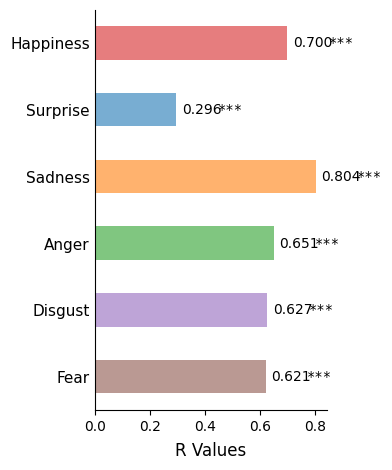

In [13]:
import matplotlib.pyplot as plt
import numpy as np

values = stats.pearsonr(preds_smoothed, danmu_human_smoothed)[0][::-1]
labels = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"][::-1]
six_colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b'][::-1]

y = np.arange(len(values))
fig, ax = plt.subplots(figsize=(3., 5.2))

bars = ax.barh(y, values, color=six_colors, height=0.5,alpha=0.6)

# y 轴设置
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=11)
ax.set_ylim(-0.5, len(values) - 0.5)

# ✅ 添加 x 轴 label
ax.set_xlabel("R Values", fontsize=12, labelpad=6)

# ✅ 移除 y 轴“突出来的短线”
ax.tick_params(axis='y', length=0)  # 隐藏小短线
# ax.spines['left'].set_visible(False)  # 如果你只要文本，不要线条，可以加上这句

# 美化
ax.xaxis.set_ticks_position('bottom')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 数值标签
for rect, v in zip(bars, values):
    ax.text(rect.get_width() + 0.02,
            rect.get_y() + rect.get_height() / 2,
            f"{v:.3f}", va='center', ha='left', fontsize=10)
    ax.text(rect.get_width() + 0.15,
            rect.get_y() + rect.get_height() / 2,
            "***",fontfamily='monospace',
            va='center', ha='left', fontsize=10)
#plt.tight_layout()
plt.savefig('figures/danmu_huamn_pearsonr.svg', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Windows\AppData\Local\Temp\ipykernel_54560\508808960.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


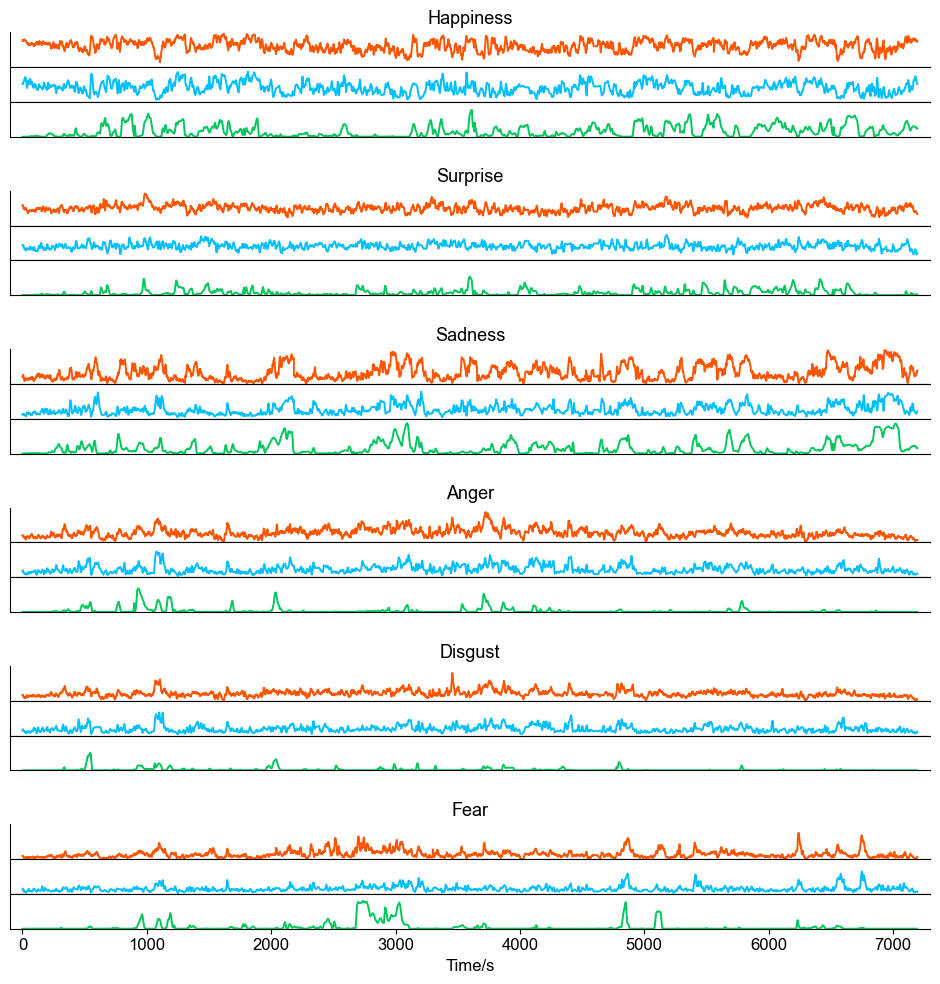

In [14]:
# Long movie
import h5py
from copy import deepcopy
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
# emos = ["Happiness", "Sadness", "Anger"]
# colors = ['#FFB6C1', '#FF7F00', '#A6D854']
colors = ['#FF5500', '#00BFFF', '#00C85D']
danmu_human_smoothed_rescale = danmu_human_smoothed / 100. * 7.

vertical_gap_small = 0.001
vertical_gap_large = 0.06
height = 0.058*2/3
left1 = 0.05
right1 = 0.97
width = right1 - left1

fig = plt.figure(figsize=(10, 9))
plt.rcParams['font.family'] = 'Arial'
sel_inds = np.arange(6)
count = 0
for j in range(6):
    bottom1 = 1 - (j+1)*height*3 - j*vertical_gap_large
    bottom2 = bottom1 + height
    bottom3 = bottom1 + 2*height
    R = np.corrcoef(preds_smoothed[:,sel_inds[count]], ratings_smoothed[:,sel_inds[count]])[0,1]
    
    ax1 = fig.add_axes([left1, bottom3, width, height])
    ax1.plot(np.arange(preds_smoothed.shape[0])*2, preds_smoothed[:, sel_inds[count]], color=colors[0], linewidth=1.4)
    ax1.set_ylim([0, 7])
    ax1.set_xlim([-100,preds_smoothed.shape[0]*2+100])
    ax1.set_title(emos[sel_inds[count]], fontsize=13)
    # ax1.set_yticks([0,4], [0,4], fontsize=10)
    ax1.set_yticks([])
    ax1.set_xticks([])
    # ax1.set_ylabel('LLM ratings for Danmu', fontsize=10, rotation=0, labelpad=60)
    # ax1.yaxis.label.set_position((0, 0.3))
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    
    ax2 = fig.add_axes([left1, bottom2, width, height])
    ax2.plot(np.arange(preds_smoothed.shape[0])*2, danmu_human_smoothed_rescale[:, sel_inds[count]], color=colors[1], linewidth=1.4)
    ax2.set_ylim([0, 7])
    ax2.set_xlim([-100,preds_smoothed.shape[0]*2+100])
    # ax2.set_title(emos[j], fontsize=15)
    # ax2.set_yticks([0,4], [0,4], fontsize=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    # ax2.set_ylabel('Human ratings for the movie', fontsize=10, rotation=0, labelpad=70)
    # ax2.yaxis.label.set_position((0, 0.3))
    ax2.spines['right'].set_visible(False)    
    
    ax3 = fig.add_axes([left1, bottom1, width, height])
    ax3.plot(np.arange(preds_smoothed.shape[0])*2, ratings_smoothed[:, sel_inds[count]]/100.*7., color=colors[2], linewidth=1.4)
    ax3.set_ylim([0, 7])
    ax3.set_xlim([-100,preds_smoothed.shape[0]*2+100])
    # ax3.set_yticks([0,4], [0,4], fontsize=10)
    ax3.set_yticks([])
    ax3.set_xticks([])
    # ax3.set_ylabel('Human ratings for the movie', fontsize=10, rotation=0, labelpad=70)
    # ax3.yaxis.label.set_position((0, 0.3))
    
    ax3.spines['right'].set_visible(False)
    
    count += 1
    
ax3.set_xlabel('Time/s', fontsize=12)
ax3.set_xticks(np.arange(0,preds_smoothed.shape[0]*2,1000), np.arange(0,preds_smoothed.shape[0]*2,1000), fontsize=12)

plt.tight_layout()
# plt.savefig('figures/prompt_v4_gpt3_5_turbo_longMovie_lineplot_human_danmu.svg', dpi=300, bbox_inches='tight')
plt.show()


In [15]:
import matplotlib.patches as patches

def highlight_regions(ax, spans, *, alpha=0.25, fc='0.8', ec='0.4',
                      lw=1.0, ls='--', zorder=0):

    ymin, ymax = ax.get_ylim()
    for s, e in spans:
        rect = patches.Rectangle((s, ymin), e - s, ymax+0.3 - ymin,
                                 facecolor=fc, edgecolor=ec,
                                 linewidth=lw, linestyle=ls,
                                 alpha=alpha, zorder=zorder)
        ax.add_patch(rect)


In [16]:
highlight_spans = [(1800, 2200), (2447, 2847), (4600, 5000)]


C:\Users\Windows\AppData\Local\Temp\ipykernel_54560\357385094.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


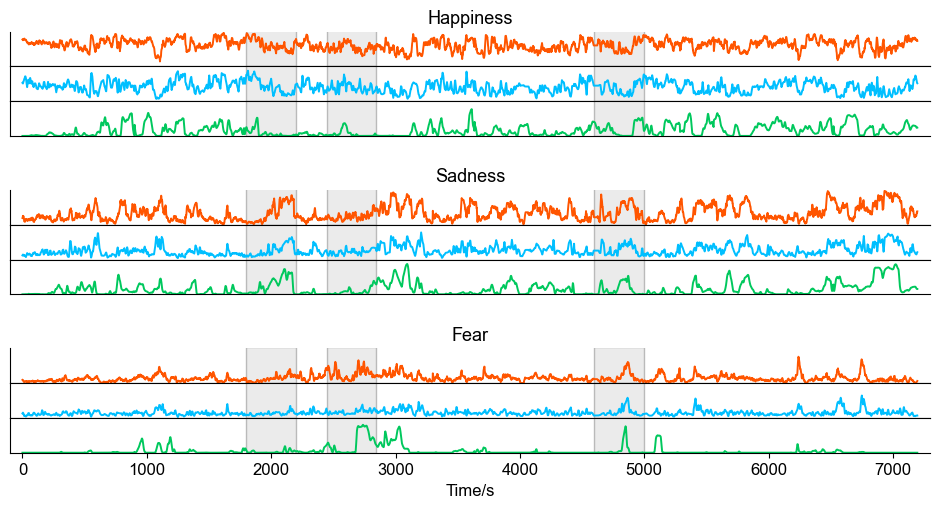

In [17]:
# Long movie
import h5py
from copy import deepcopy
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
#emos = ["Happiness", "Sadness", "Anger"]
# colors = ['#FFB6C1', '#FF7F00', '#A6D854']
colors = ['#FF5500', '#00BFFF', '#00C85D']
danmu_human_smoothed_rescale = danmu_human_smoothed / 100. * 7.

vertical_gap_small = 0.001
vertical_gap_large = 0.06
height = 0.058*2/3
left1 = 0.05
right1 = 0.97
width = right1 - left1

fig = plt.figure(figsize=(10, 9))
plt.rcParams['font.family'] = 'Arial'
sel_inds = np.arange(6)
count = 0
for i,j in enumerate([0,2,5]):
    bottom1 = 1 - i*height*3 - i*vertical_gap_large
    bottom2 = bottom1 + height
    bottom3 = bottom1 + 2*height
    R = np.corrcoef(preds_smoothed[:,j], ratings_smoothed[:,j])[0,1]
    
    ax1 = fig.add_axes([left1, bottom3, width, height])
    ax1.plot(np.arange(preds_smoothed.shape[0])*2, preds_smoothed[:, j], color=colors[0], linewidth=1.4)
    ax1.set_ylim([0, 7])
    ax1.set_xlim([-100,preds_smoothed.shape[0]*2+100])
    ax1.set_title(emos[j], fontsize=13)
    # ax1.set_yticks([0,4], [0,4], fontsize=10)
    ax1.set_yticks([])
    ax1.set_xticks([])
    # ax1.set_ylabel('LLM ratings for Danmu', fontsize=10, rotation=0, labelpad=60)
    # ax1.yaxis.label.set_position((0, 0.3))
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    
    ax2 = fig.add_axes([left1, bottom2, width, height])
    ax2.plot(np.arange(preds_smoothed.shape[0])*2, danmu_human_smoothed_rescale[:, j], color=colors[1], linewidth=1.4)
    ax2.set_ylim([0, 7])
    ax2.set_xlim([-100,preds_smoothed.shape[0]*2+100])
    # ax2.set_title(emos[j], fontsize=15)
    # ax2.set_yticks([0,4], [0,4], fontsize=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    # ax2.set_ylabel('Human ratings for the movie', fontsize=10, rotation=0, labelpad=70)
    # ax2.yaxis.label.set_position((0, 0.3))
    ax2.spines['right'].set_visible(False)    
    
    ax3 = fig.add_axes([left1, bottom1, width, height])
    ax3.plot(np.arange(preds_smoothed.shape[0])*2, ratings_smoothed[:, j]/100.*7., color=colors[2], linewidth=1.4)
    ax3.set_ylim([0, 7])
    ax3.set_xlim([-100,preds_smoothed.shape[0]*2+100])
    # ax3.set_yticks([0,4], [0,4], fontsize=10)
    ax3.set_yticks([])
    ax3.set_xticks([])
    # ax3.set_ylabel('Human ratings for the movie', fontsize=10, rotation=0, labelpad=70)
    # ax3.yaxis.label.set_position((0, 0.3))
    
    ax3.spines['right'].set_visible(False)
    highlight_regions(ax1, highlight_spans, alpha=0.5, fc='0.85', ec='0.5', lw=1.0, ls='-', zorder=0)

    highlight_regions(ax2, highlight_spans, alpha=0.5, fc='0.85', ec='0.5', lw=1.0, ls='-', zorder=0)

    highlight_regions(ax3, highlight_spans, alpha=0.5, fc='0.85', ec='0.5', lw=1.0, ls='-', zorder=0)

    count += 1
    
ax3.set_xlabel('Time/s', fontsize=12)
ax3.set_xticks(np.arange(0,preds_smoothed.shape[0]*2,1000), np.arange(0,preds_smoothed.shape[0]*2,1000), fontsize=12)

plt.tight_layout()
plt.savefig('prompt_v4_gpt3_5_turbo_longMovie_lineplot_human_danmu.svg', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
preds_smoothed.shape, danmu_human_smoothed.shape, ratings_smoothed.shape

((3599, 6), (3599, 6), (3599, 6))

In [19]:
preds_smoothed.shape, danmu_human_smoothed.shape, ratings_smoothed.shape

((3599, 6), (3599, 6), (3599, 6))

In [20]:
import numpy as np

def kabsch_align_to_ref(ref, X, with_scale=True):

    R0, X0 = ref - ref.mean(0), X - X.mean(0)
    sR = np.sqrt((R0**2).sum()); sX = np.sqrt((X0**2).sum())
    if with_scale:
        Rn, Xn = R0/sR, X0/sX
    else:
        Rn, Xn = R0, X0

    H = Xn.T @ Rn
    U, S, Vt = np.linalg.svd(H)
    Rm = Vt.T @ U.T
    if np.linalg.det(Rm) < 0:  
        Vt[-1, :] *= -1
        Rm = Vt.T @ U.T

    X_rot = Xn @ Rm
    if with_scale:
        X_rot = X_rot * (sR/sX)
    X_aligned = X_rot + ref.mean(0)
    return X_aligned


In [21]:
import numpy as np
from scipy.stats import pearsonr

def rolling_top3_corr(A, B, win=100, step=100):

    assert A.shape == B.shape and A.shape[1] == 6, "输入应为 (T,6)"
    T = A.shape[0]
    results, idxs = [], []
    all_r = []

    for start in range(0, T - win + 1, step):
        end = start + win
        r_all = []
        for d in range(6):
            a, b = A[start:end, d], B[start:end, d]
            # 检查常数序列
            if np.std(a) < 1e-8 or np.std(b) < 1e-8:
                r = 0.0
            else:
                r, _ = pearsonr(a, b)
                if np.isnan(r):
                    r = 0.0
            r_all.append(r)
        r_all = np.array(r_all)

        top3_idx = np.argsort(np.abs(r_all))[-3:][::-1]
        top3_vals = r_all[top3_idx]
        avg_top3 = np.mean(np.abs(top3_vals))

        results.append(avg_top3)
        idxs.append((start, end))
        all_r.append((r_all, top3_idx, top3_vals))

    results = np.array(results)
    best_i = np.argmax(results)
    best_start, best_end = idxs[best_i]
    _, top3_idx, top3_vals = all_r[best_i]

    print("✅ 最佳窗口:")
    print(f"  时间范围: [{best_start} : {best_end}]")
    print(f"  平均最高相关: {results[best_i]:.4f}")
    print(f"  最相关的三个维度: {top3_idx.tolist()}")
    for i, d in enumerate(top3_idx):
        print(f"    维度 {d}: r = {top3_vals[i]:.4f}")

    return np.array([s + (e - s)//2 for s, e in idxs]), results


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

def smooth_ma(X, win=None):
    if win is None or win <= 1: return X
    Y = np.empty_like(X, dtype=float)
    T = len(X); half = win // 2
    for t in range(T):
        s = max(0, t-half); e = min(T, t+half+1)
        Y[t] = X[s:e].mean(axis=0)
    return Y

def _center(X, how='t0', win=50):
    if how is None: return X
    if how == 't0':
        return X - X[0]
    elif how == 'mean':
        return X - X.mean(axis=0)
    elif how == 'window':
        w = min(win, len(X))
        return X - X[:w].mean(axis=0)
    elif how == 'min':    return X - X.min(axis=0, keepdims=True)  # 👈 新增
    else:
        raise ValueError("how must be in {'t0','mean','window',None}")

def _normalize(X, method='zscore'):
    if method is None: 
        return X
    if method == 'zscore':  # z-score标准化
        std = X.std(axis=0, keepdims=True)
        std[std < 1e-8] = 1.0
        return (X - X.mean(axis=0, keepdims=True)) / std
    elif method == 'minmax':
        minv, maxv = X.min(axis=0, keepdims=True), X.max(axis=0, keepdims=True)
        return (X - minv) / (maxv - minv + 1e-8)
    else:
        raise ValueError("normalize must be None|'zscore'|'minmax'")


In [23]:
time_stamp=[902,882,876,976,924,878,1084,675]
time_stamp=[sum(time_stamp[:i]) for i in range(len(time_stamp)+1)]
time_stamp

[0, 902, 1784, 2660, 3636, 4560, 5438, 6522, 7197]

In [ ]:
# import cv2

# def extract_frame(video_path, time_sec, save_path=None):
#     cap = cv2.VideoCapture(video_path)
#     fps = cap.get(cv2.CAP_PROP_FPS)                 # 每秒帧数
#     frame_no = int(fps * time_sec)                  # 目标帧编号
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)      # 跳转到指定帧

#     success, frame = cap.read()
#     if not success:
#         print("❌ 无法读取该时间点的帧")
#         cap.release()
#         return None

#     # 转换 BGR → RGB 以便 matplotlib 显示
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     if save_path:
#         cv2.imwrite(save_path, frame)               # 保存原始BGR格式图片
#         print(f"✅ 已保存帧到: {save_path}")

#     cap.release()
#     return frame_rgb

# def extract_frame_vector(video_path, time_sec, save_path=None):
#     cap = cv2.VideoCapture(video_path)
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     frame_no = int(fps * time_sec)
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

#     success, frame = cap.read()
#     if not success:
#         print("❌ 无法读取该时间点的帧")
#         cap.release()
#         return None

#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     cap.release()

#     # 用 matplotlib 画出来（无锯齿，可保存为 svg/pdf）
#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.imshow(frame_rgb)
#     ax.axis('off')

#     if save_path:
#         if save_path.endswith('.svg') or save_path.endswith('.pdf'):
#             plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#             print(f"✅ 已保存矢量格式图像到: {save_path}")
#         else:
#             plt.savefig(save_path + '.svg', bbox_inches='tight', pad_inches=0)
#             print(f"✅ 已保存矢量格式图像到: {save_path}.svg")

#     plt.show()
#     return frame_rgb



In [ ]:
# want=1115
# for i in range(len(time_stamp)):
#     if want<time_stamp[i]:
#         video_index=i-1
#         break
# frame_img = extract_frame_vector(
#     f"/mnt/dataset1/xinke/Danmu/Forrest/fgav/fg_av_ger_seg{video_index}.mkv",
#     time_sec=want-time_stamp[video_index],     # 想提取的秒数
#     save_path=f"frame_{want}s.svg"
# )

❌ 无法读取该时间点的帧


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_trajs3d(trajs, labels=None, starts=None, ends=None,
                 smooth_win=None, center='t0',
                 normalize='zscore', emos=['dim0','dim1','dim2'],
                 color_by_time=False, linewidth=2.0, colors=None,
                 mark_start_end=True, title=None,
                 special_idx=None,            
                 special_marker='s',          
                 special_size=60,             
                 special_color=None,         
                 special_label='Event',
                 leng_show=True,
                 fig_size=(10,6),font_size=14,axis_off=False,
                 box_aspect=[1.2, 1.2, 0.8],save_path=None
                 ):      

    n = len(trajs)
    if labels is None: labels = [f"traj{i+1}" for i in range(n)]
    if starts is None: starts = [0]*n
    if ends   is None: ends   = [len(trajs[i]) for i in range(n)]
    if colors is None: colors = [None]*n

    fig = plt.figure(figsize=fig_size)
    ax  = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect(box_aspect)  # x:y:z = 1.2:1.2:0.6

    ax.grid(False)
    ax.xaxis.pane.set_facecolor((1,1,1,0))
    ax.yaxis.pane.set_facecolor((1,1,1,0))
    ax.zaxis.pane.set_facecolor((1,1,1,0))
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.line.set_color((0,0,0,0.2))
    fig.patch.set_facecolor('white')

    box = ax.get_position()
    #ax.set_position([box.x0, box.y0, box.width*0.78, box.height])

    line_handles = []
    used_colors  = []
    ax.view_init(elev=25, azim=-60)
    for i, X in enumerate(trajs):
        s, e = starts[i], ends[i]
        seg = smooth_ma(X, win=smooth_win)[s:e]

        seg = _normalize(seg, method=normalize)
        seg = _center(seg, how=center, win=50)

        c = colors[i] if colors[i] is not None else f"C{i}"
        used_colors.append(c)

        ax.plot(seg[:,0], seg[:,1], seg[:,2], linewidth=linewidth, color=c)

        if mark_start_end and len(seg) > 0:
            ax.scatter(seg[0,0], seg[0,1], seg[0,2], s=120, marker='o', color=c)
            ax.scatter(seg[-1,0], seg[-1,1], seg[-1,2], s=180, marker='^', color=c)

        if special_idx is not None:
            if isinstance(special_idx, int):
                idxs = [special_idx]
            else:
                idxs = special_idx
            for idx in idxs:
                if 0 <= idx < len(seg):
                    sc = special_color if special_color else c
                    ax.scatter(seg[idx,0], seg[idx,1], seg[idx,2],
                               s=150, marker=special_marker,
                               color=sc, edgecolors='none')

        line_handles.append(Line2D([0],[0], color=c, lw=linewidth, label=labels[i]))

    if title: ax.set_title(title)
    # ax.set_xlabel(emos[0], fontsize=font_size); ax.set_ylabel(emos[1], fontsize=font_size); ax.set_zlabel(emos[2], fontsize=font_size, labelpad=15)
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_zticks([0,1])
    ax.set_xlim([0,1]); ax.set_ylim([0,1]); ax.set_zlim([0,1])
    #ax.set_zlabel("Fear")
    # ---- make axes darker ----
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_color('black')
        axis.label.set_color('black')
        axis.set_tick_params(colors='black')
    if axis_off:
        ax.set_axis_off()
    start_handle = Line2D([0],[0], marker='o', color='none',
                          markerfacecolor='black', markeredgecolor='black',
                          linestyle='None', label='Start (o)')
    end_handle   = Line2D([0],[0], marker='^', color='none',
                          markerfacecolor='black', markeredgecolor='black',
                          linestyle='None', label='End (▲)')

    extra_handles = []
    if special_idx is not None:
        extra_handles.append(Line2D([0],[0], marker=special_marker, color='none',
                                    markerfacecolor='black', markeredgecolor='black',
                                    linestyle='None', label=f'{special_label} ({special_marker})'))

    all_handles = line_handles + [start_handle, end_handle] + extra_handles
    if leng_show:
        fig.legend(handles=all_handles, loc='center left', bbox_to_anchor=(0.80, 0.5),
               frameon=True, fontsize=10)
    #plt.tight_layout()
    fig.subplots_adjust(top=1, bottom=0, left=0, right=1)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


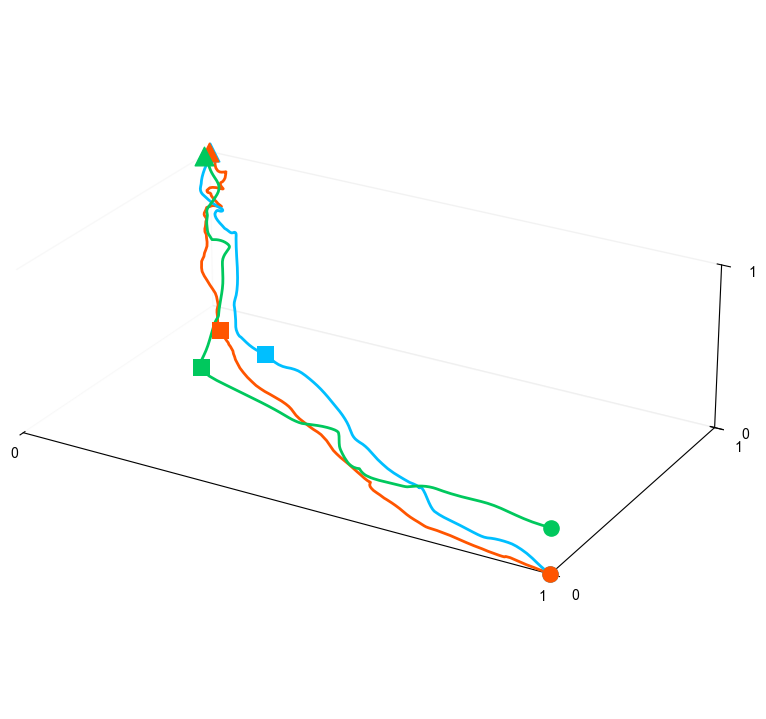

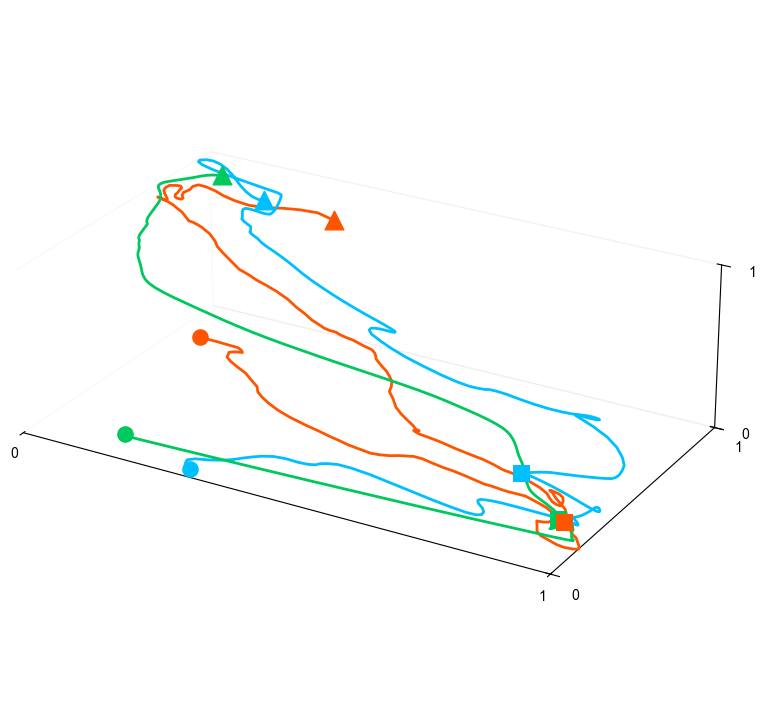

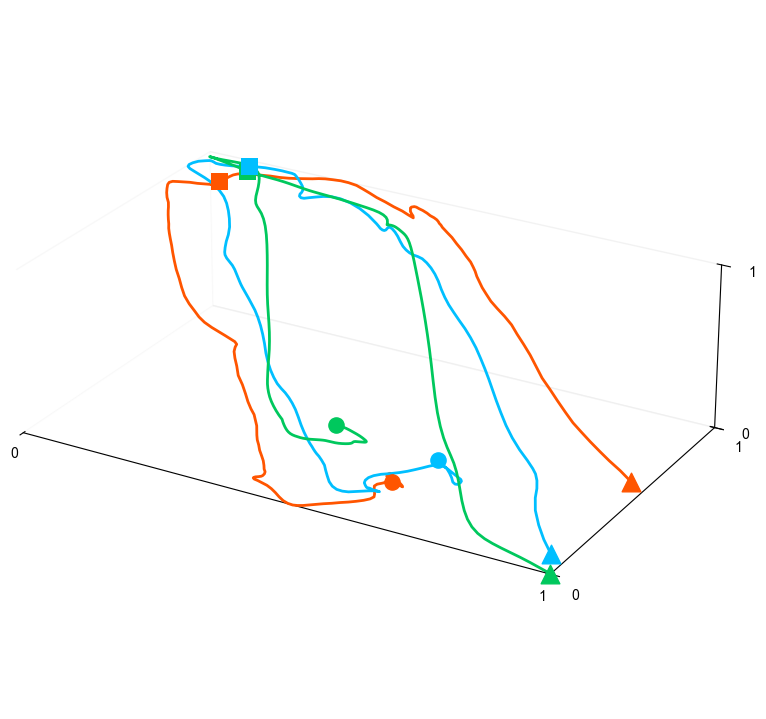

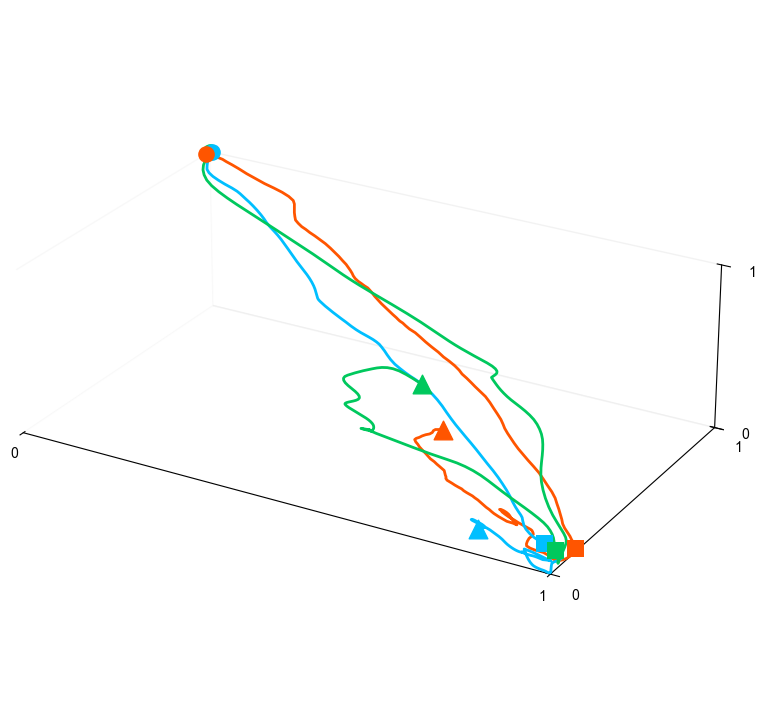

In [28]:
colors = ['#FF5500', '#00BFFF', '#00C85D']
begin_list=(np.array([1800,2447,4600,4800])/2).astype(int).tolist()
# time 2300
middle_list=[99,75,121,100]
for i,begin in enumerate(begin_list):
    end = begin + 200
    choose_emo = np.array([0,2,5])
    plot_trajs3d([preds_smoothed[begin:end,choose_emo], danmu_human_smoothed[begin:end,choose_emo],7*ratings_smoothed[begin:end,choose_emo]/np.max(ratings_smoothed[begin:end,choose_emo]),
                  ],special_idx=[middle_list[i]],box_aspect=[5,3,1.5],font_size=16,axis_off=False,
                 center='min',normalize='minmax', smooth_win=100, emos=np.array(emos)[choose_emo].tolist(),
                 colors=colors, labels=['LLM ratings for Danmu', 'Human ratings for movie', 'Human ratings for Danmu'],leng_show=False,
                 fig_size=(10,7),save_path=f'3d_traj_with_events_time_{begin*2}_{end*2}s.svg'
                 #,title=f"time {begin*2}-{end*2}s",
                 )
